In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.data import load
from fastai.callback.tracker import SaveModelCallback
from fastprogress import fastprogress

from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision.transforms as T
import torch
from torch.nn.parallel import DistributedDataParallel
from torchvision.transforms.functional import *

from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn

import argparse
from models.utils.joiner2 import Joiner
from models.utils.new_losses import *
from models.utils.metrics import Accuracy, Curating_Of_Attention_Loss
from models.utils.dataLoader import *
from models.utils.datasets import *
import webdataset as wds

In [2]:
torch.cuda.set_device("cuda:0")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
#PARAMETERS

train_path  = "data/GramCifar/train/train_CustomCifar_4x4GridLabel_full.tar"
valid_path = "data/GramCifar/train/train_CustomCifar_4x4GridLabel_full.tar"

H = 32
W= 32
bs = 5
grid_l = 2
nclass = 4
use_patches = True
epochs = 5

beta = 0#.0005
gamma = 0.0005
sigma = 1.0

In [4]:
#Loading the DataSets
train_ds = torch.load(train_path)
valid_ds = torch.load(valid_path)
#LoadGramDataset(train_path, valid_path, normalize=False)

In [5]:
#Creating the dataloader
dloader = GramCifarLoader(train_ds, valid_ds, bs)

In [6]:
#Defining the Loss Function
critic_loss = CriticLoss(beta=beta, sigma=sigma).to(device)

In [17]:
#Building the model
model = Joiner(num_encoder_layers = 8, nhead=8, use_patches = backbone, num_classes = nclass, bypass=False, hidden_dim=768, 
batch_size=bs, image_h=H, image_w=W, grid_l=1,penalty_factor="1")

In [18]:
test = model(train_ds[0][0].unsqueeze(0))#.permute(1, 2, 0))
print("Shape out1:", test[0].shape)
print("Len out2:", len(test[1]))
print("Shape out2:", test[1][0].shape)
print("Category:", test[2])

Shape out1: torch.Size([1, 4])
Len out2: 8
Shape out2: torch.Size([1, 1024, 1024])
Category: tensor([0])


In [19]:
#Wraping the Learner
learner = Learner(dloader, model, loss_func=critic_loss, metrics=[Accuracy,Curating_Of_Attention_Loss])

SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=3.0199516913853586e-05)

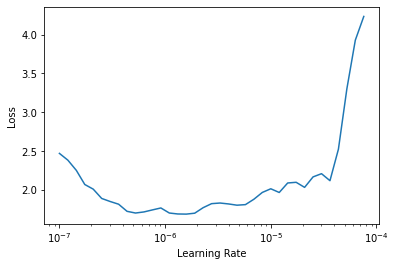

In [20]:
#Finding the best learning rate
learner.lr_find()

In [ ]:
#Fitting the model
learner.fit(10, 4e-7)

In [17]:
model_dir = Path.home()/'Luiz/saved_models'
learner.export(model_dir/'test.pkl')

In [15]:
model_dir = "../saved_models/"
file_name = "GramCifar_epochs-"+"20"+"-beta-"+"1e-4"+"_lr-"+"1e-7"+".pkl"
torch.save(learner.model,model_dir+file_name)

In [ ]:
#THE TRAINING LOOP
# model outputs -> [x, sattn, pattn, inputs, x0]

running_loss_history = [] # training loss - to generate a plot
running_acc_history = [] # traning accuracy
running_latt_history = [] # traning accuracy

val_running_loss_history = [] # validation loss
val_running_acc_history = [] # validation accuracy

for e in range(epochs):
  
    start_time = time.time()
    print('Epoch {}/{}'.format(e+1, epochs))
    print('-' * 10)

    running_loss = 0.0
    running_acc = 0.0
    running_latt = 0.0
    
    val_running_loss = 0.0
    val_running_acc = 0.0
    
    batch=0
    
    for inputs, labels in train_loader:
        
        batch+=1
        sys.stdout.write('\rBatch: %d' %batch)
        sys.stdout.flush()

        #TRAINING
        inputs = inputs.to(device) # allow gpu use
        labels[0] = labels[0].to(device)
        labels[1] = labels[1].to(device)# allow gpu use
        outputs = model(inputs) #gives the output of the last layer
        loss = train_loss(outputs, labels) # comparing outputs and labels using the criteria
        
        optimizer.zero_grad() #zero the grad
        loss.backward() #backpropagation
        optimizer.step() #optimize weights 

        #COMPUTING TRAINING METRICS
        acc = Accuracy(outputs,labels)
        latt = Curating_Of_Attention_Loss(outputs,labels)
        
        running_loss += loss.item() # the sum of the loss of all itens
        running_acc += acc
        running_latt += latt
        
        Typenone = 0
        zeros = 0
        normal = 0
        for name, param in model.named_parameters():
            if param.grad == None:
                Typenone +=1
            elif torch.sum(param.grad) == 0:
                zeros += 1
            else:
                normal += 1
        if Typenone >10:
            print("None parameters:",Typenone)
            for name, param in model.named_parameters():
                if param.grad == None:
                    print(name)
        if zeros > 5:
            print("Zero Grad Parameters:", zeros)
        #print("Normally computed Parameters:",normal)
                
                
    else:
        #VALIDATION
        with torch.no_grad(): # to save memory (temporalely set all the requires grad to be false)
            for val_inputs, val_labels in valid_loader:
                val_inputs = val_inputs.to(device) # allow gpu use
                val_labels = val_labels.to(device) # allow gpu use
                val_outputs = model(val_inputs) #passes the image through the network and get the output
                val_loss = valid_loss(val_outputs, val_labels) #compare output and labels to get the loss 

                val_acc = Accuracy(val_outputs,val_labels)
                val_running_loss += val_loss.item() #same as for training
                val_running_acc += val_acc
                
    #Adding one step to the optimizer            
    model_lr_scheduler.step()
    
    #TRAINING LOSS AND ACCURACY
    epoch_loss = running_loss/len(train_ds) # the sum of the loss of all itens divided by the number of itens
    epoch_acc = running_acc/len(train_loader) # the sum of correct predictions divided by the number of itens
    epoch_latt = running_latt/len(train_loader)
    
    running_loss_history.append(epoch_loss) #append to respective list
    running_acc_history.append(epoch_acc) #append to respective list
    running_latt_history.append(epoch_latt) #append to respective list

    #VALIDATION LOSS AND ACCURACY
    val_epoch_loss = val_running_loss/len(valid_ds)
    val_epoch_acc = val_acc/ len(valid_loader)
    
    val_running_loss_history.append(val_epoch_loss) #append to respective list
    val_running_acc_history.append(val_epoch_acc) #append to respective list
    
    
    epoch_time_elapsed = time.time() - start_time
    print('Epoch training complete in {:.0f}m {:.0f}s'.format(
            epoch_time_elapsed // 60, epoch_time_elapsed % 60))
    print('training loss: {:.4f}, acc {:.4f}, noised acc {:.4f} '.format(epoch_loss, epoch_acc.item(), epoch_noised_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))